In [ ]:
# MIT License
#
#@title Copyright (c) 2023 CCAI Community Authors { display-mode: "form" }
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# NLP Models for Climate Policy Analysis Part 2: Prompts for Sustainable Development Goals


Author(s):
*   Daniel Spokoyny, Carnegie Mellon University, dspokoyn@cs.cmu.edu
*   Tobias Schimanski, University of Zurich, tobias.schimanski@df.uzh.ch


# Table of Contents

*   [Target Audience](#target-audience)
*   [Overview](#overview)
*   [Contributions](#contributions)
*   [Software Requirements](#software-requirements)
*   [Data Source](#data-source)
*   [Simple Prompt](#simple-prompt)
*   [In-Context Learning Prompts](#icl-prompt)

<a name="target-audience"></a>
# Target Audience

* Climate scientists seeking to use large language models to tackle a domain-specific problem in climate change.
* Data scientists with prior background in deep learning who are interested in building prompt-based large language model classifiers for climate texts.

<a name="Motivation"></a>
# Motivation

The Paris Agreement is an international treaty on climate change that was adopted in 2015.
One of the results of the treaty is that all participating countries are required to submit a Nationally Determined Contribution (NDC) report every five years.
These reports include a variety of vital information, such as the country's current greenhouse gas emissions, their goals for reducing emissions, and the policies they plan to implement to achieve these goals.
Since these reports are written in plain text and can be hundreds of pages long, many questions are difficult to answer automatically, such as:
*   What are the most common policies that countries are implementing to reduce emissions?
*   Which countries are on track to meet their goals?
*   Which countries are falling behind?
*   What are the most common barriers to reducing emissions?

One way to better understand these reports would be to use a common framework to help organize the information.
The Sustainable Development Goals (SDG) framework aims to provide a set of 17 climate goals (e.g. "Affordable and Clean Energy") with even more subgoals (or targets) that can be used to organize the information in the NDC reports.

Climate Watch, is a project by the World Resources Institute that has manually aligned the unstructured texts of the Nationally Determined Contribution reports to the semi-structured Sustainable Development Goals (SDG) framework.\footnote{https://www.climatewatchdata.org/}
By doing so, Climate Watch allows for different stakeholders to more easily compare progress across countries and identify which areas need financing, education, policy changes or other resources.

In this tutorial, we will build a prompt-based classifier and use this dataset to evaluate the performance of the classifier.
Since new documents are being updated, a tool that can automatically align NDC reports to the SDG framework would save a lot of time and effort.

<a name="overview"></a>
# Overview: OpenAI Classification Extraction with Prompt Based In-Context Learning

In this tutorial we will use the OpenAI Large Language Models (LLMs) to classify climate policy documents.
For the data we will work with the Nationally Determined Contributions (NDCs) documents from the Paris Climate Agreement. As the model we will use OpenAI's 'gpt-3.5-turbo-0125' (backbone of the base ChatGPT) and attempt to use carefully crafted prompts to classify sentences from our dataset.

While in the previous tutorial we were focused on training supervised NLP models for text classification, with the advent of LLMs a more recent paradigm, prompting, has emerged. Prompting allows for interfacing with a trained machine learning model using text as input and text as output.

The rest of the tutorial is organized as follows

(1) **Dataset**: We are going to load the dataset and get it ready for prompt classification. \
(2) **Prompting**: We are going to construct a simple prompt and use it to classify sentences. \
(3) **ICL**: We are going to add to the prompt in-context learning examples and also increase the context of the input text.


<a name="contributions"></a>
# Contributions

Through introductory presentations and colab notebooks, we aim to expose the participants to:

(a) **Dataset**: Outlining a dataset of national climate action plans with corresponding annotations to the Sustainable Development Goals framwork. \
(b) **Prompting**: Designing prompts with in-context learning to perform novel text classification tasks. \
(c) **LLMs**: Using large language models (LLMs) via python web-based APIs. \

<a name="software-requirements"></a>
# Software Requirements
This notebook requires the following libraries:
*   datasets (pip)
*   openai (pip)

`datasets` is a library which we will use to download the data required.
`openai` is a library from which we can access large language models via a python API. To use the model, you will need to sign up for an OpenAI Account (http://platform.openai.com/signup) and get an API key pasted below.


In [ ]:
# We need to install the following packages to run the code in this notebook
# %%capture
!pip install datasets
!pip install openai
!pip install llama_index

In [ ]:
# Import libraries
import openai
from openai import OpenAI
import json
from huggingface_hub import hf_hub_download
from datasets import load_dataset

In [ ]:
# This here is how we will load the SDG dataset from the HuggingFace Hub.
# It has already been preprocessed for you to use.
dataset = load_dataset("dspoka/sdg-single")

# Here we will transform the dataset into a pandas dataframe
df_full = dataset['full'].to_pandas()

print(f'The dataset has {df_full.shape[0]} rows and {df_full.shape[1]} columns')
print(f'The columns are: {df_full.columns.values}')
df_full.head()

The dataset has 14219 rows and 13 columns
The columns are: ['iso3' 'country' 'goal' 'target' 'text' 'status' 'sector' 'response'
 'infotype' 'start' 'end' 'filename' '__index_level_0__']


,iso3,country,goal,target,text,status,sector,response,infotype,start,end,filename,__index_level_0__
0,AFG,Afghanistan,12,12.2,Reduce rural peoples’ dependence on fuel for c...,future,energy efficiency,mitigation,needs_and_gaps,28031.0,28096.0,AFG-first_ndc-EN.html,0
1,AFG,Afghanistan,1,1.5,Reducing vulnerability of the country and its ...,future,health,adaptation,action,12482.0,12648.0,AFG-first_ndc-EN.html,1
2,AFG,Afghanistan,13,13.1,Reducing vulnerability of the country and its ...,future,health,adaptation,action,12482.0,12648.0,AFG-first_ndc-EN.html,2
3,AFG,Afghanistan,15,15.2,Regeneration of at least 40% of existing degra...,not_specified,not_specified,not_specified,not_specified,19765.0,19906.0,AFG-first_ndc-EN.html,3
4,AFG,Afghanistan,7,7.2,"Renewable energy, entry costs support, access ...",future,renewable energy,mitigation,needs_and_gaps,27461.0,27532.0,AFG-first_ndc-EN.html,4


<a name="data-source"></a>
# Understanding the SDG Dataset
- The important columns for us to know are 'goal', and 'text'.
- The 'text' column is the raw text that was annotated in the NDC documents. We will feed this into our model and use it to predict the the label.
- The 'goal' column is the SDG goal. We will use this as our main label for prediction.
- Each SDG 'goal' also has sub-goals or 'target' as the name of the column.
- Currently, if you take a look the goals they are ["1",...,"17"]. Goal "12" may have a target "12.2".
- What does goal "12" stand for exactly? Well for this, we need to take a look at the metadata.
- Below, is an image that shows the 2030 progerss for the SDG goals and targets.
![SDG Goals](https://unece.org/sites/default/files/styles/max_1300x1300/public/2021-03/Graphic%20EN%20_PR_SDG%20Report.png?itok=Mwuuj3c7)


In [ ]:
def unpack_and_explain_metadata(metadata):
    '''Args:
        metadata: dictionary containing the metadata for the dataset.
    Returns:
        goal_idx_2_description: dictionary mapping goal index to the text description of the goal.
        goal_idx_2_goal_number: dictionary mapping goal index to the goal number. The goal number is what is currently in the dataset frame.
        target_idx_2_description: dictionary mapping target index to the text description of the target.
        target_idx_2_goal_idx: dictionary that maps a target index to the goal index. There are multiple targets per goal.
        target_idx_2_target_number: dictionary that maps a target index to the target number. The target number is what is currently in the dataset frame.

    '''
    goal_idx_2_description = metadata['goal_idx_2_description']
    goal_idx_2_description = {int(k):v for k,v in goal_idx_2_description.items()}

    goal_idx_2_goal_number = metadata['goal_idx_2_goal_number']
    goal_idx_2_goal_number = {int(k):v for k,v in goal_idx_2_goal_number.items()}

    target_idx_2_description = metadata['target_idx_2_description']
    target_idx_2_description = {int(k):v for k,v in target_idx_2_description.items()}

    target_idx_2_goal_idx = metadata['target_idx_2_goal_idx']
    target_idx_2_goal_idx = {int(k):int(v) for k,v in target_idx_2_goal_idx.items()}

    target_idx_2_target_number = metadata['target_idx_2_target_number']
    target_idx_2_target_number = {int(k):v for k,v in target_idx_2_target_number.items()}

    return goal_idx_2_description, goal_idx_2_goal_number, target_idx_2_description, target_idx_2_goal_idx, target_idx_2_target_number


# We will also download the metadata for the dataset from the HuggingFace Hub.
filepath = hf_hub_download(repo_id="dspoka/sdg-single", filename="metadata.json", repo_type="dataset")
with open(filepath) as f:
    metadata = json.load(f)

# In this method we will unpack the dictionaries and explain what each of the metadata means
goal_idx_2_description, goal_idx_2_goal_number, target_idx_2_description, target_idx_2_goal_idx, target_idx_2_target_number = unpack_and_explain_metadata(metadata)

### So lets look at a row of our dataset df_full and see how to use the metadata to understand it.

Understand the dataset.

In [ ]:
# first row
print(df_full.iloc[0])
# and here is the text of the first row:
print('Text', df_full.iloc[0]['text'])

iso3                                                               AFG
country                                                    Afghanistan
goal                                                                12
target                                                            12.2
text                 Reduce rural peoples’ dependence on fuel for c...
status                                                          future
sector                                               energy efficiency
response                                                    mitigation
infotype                                                needs_and_gaps
start                                                          28031.0
end                                                            28096.0
filename                                         AFG-first_ndc-EN.html
__index_level_0__                                                    0
Name: 0, dtype: object
Text Reduce rural peoples’ dependence on fuel for cook

### Looking at row
- We see that this piece of text is from the NDC of the country "Afghanistan" and from this particular file: AFG-first_ndc-EN.html
- We also see some other topic labels, such that this is about the "energy efficiency" sector, is a type of mitigation Climate Response, and that its current implementation status is "future".
- We also see that the Sustainable Development Goals (SDG) goal is "12" and target is "12.2".
- Note idx or the index is 0-indexed for both goal_idx and target_idx.


In [ ]:
goal_number = "12"
goal_idx = None
for k,v in goal_idx_2_goal_number.items():
    if v == "12":
        goal_idx = k
        break

print(f'There are {len(goal_idx_2_description)} goals in the dataset.')
print(f'The "{goal_number}" goal has this text description: {goal_idx_2_description[goal_idx]}')

There are 17 goals in the dataset.
The "12" goal has this text description:  Ensure sustainable consumption and production patterns


We can also find all targets or subgoals that belong to this goal in specific (just for understanding, we will not use these targets later on).

In [ ]:
# Find all target_ids that belong to goal 0
target_ids = []
for target_id, goal_id in target_idx_2_goal_idx.items():
    if goal_id == goal_idx:
        target_ids.append(target_id)

# And now lets print all the descriptions of the targets that belong to goal 0
for target_id in target_ids:
    print(f'Target {target_id} has the following description: {target_idx_2_description[target_id]}')

Target 0 has the following description: By 2030, achieve the sustainable management and efficient use of natural resources
Target 9 has the following description: By 2030, substantially reduce waste generation through prevention, reduction, recycling and reuse
Target 20 has the following description: Implement the 10-year framework of programmes on sustainable consumption and production, all countries taking action, with developed countries taking the lead, taking into account the development and capabilities of developing countries
Target 21 has the following description: By 2020, achieve the environmentally sound management of chemicals and all wastes throughout their life cycle, in accordance with agreed international frameworks, and significantly reduce their release to air, water and soil in order to minimize their adverse impacts on human health and the environment
Target 29 has the following description: By 2030, ensure that people everywhere have the relevant information and aw

<Axes: xlabel='goal'>

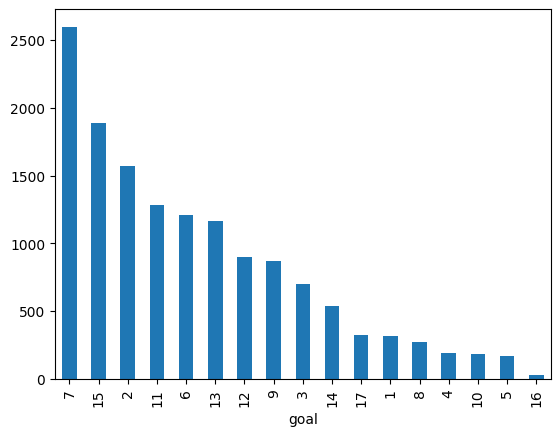

In [ ]:
# Lets also plot the histogram of goals in the dataset
df_full['goal'].value_counts().plot(kind='bar')

<a name="simple-prompt"></a>
## Using prompting to classify the text into the correct SDG goal.
- In this section we will set up the classification task that we wish to perform.
- We will feed in the text from the NDC and have the model predict the corresponding SDG goal.
- Unlike in the previous tutorial where we fine-tuned a classifier on supervised data, here we will adopt the strategy of prompting a Large Language Model (LLM) to perform this in a zero-shot and few-shot manner.
- First let's do a quick review so that we can understand what prompting is and how it works.


## Large Language Models (LLMs) and Prompting
- In the previous tutorial, we fine-tuned a classification head on top of a pretrained transformer model.
- Given a sentence the model outputted a vector of dimension 'd' and we added new parameter weights (classification head) to map this vector to a vector of dimension 'k' where 'k' is the number of classes.
- Since these classifier's parameters are randomly initialized, we needed to train them on supervised data in order to learn the correct mapping.
- This may be limiting if we have too little labeled data or its too expensive to label data.
- What if instead of introducing new parameters we could use the same underlying transformer model to also perform the classification task?


## Enter Prompting
- LLMs are typically pretrained on large amounts of unlabeled text with a self-supervised objective: predicting the next word.
- The initial idea of prompting can then be thought as: "How can we change this classification task such that it falls naturally to next word prediction?"
- Suppose we start with a sentiment classification sentence like "I loved this movie, it was a blast!" where the true label is "positive".
- We can then add a prompt or a template of the form "{Movie Review}. This movie is {sentiment}"
    - input to model: "I loved this movie, it was a blast! This movie is"
    - and we can compare the next word prediction probability of the label "positive" versus "negative".
- Whichever is higher is the label we choose.
- This is a simple example of prompting, where we reframed sentiment classification to fit with the next word prediction which allows us to use the same pretrained model without any additional parameters.

### Current LLMs and Prompting
- The simple example above gives intuition for simple prompting but in practice current LLMs are much more flexible with the types of prompts that can be used.
- They have been trained on extra datasets for following instructions so that they can perform tasks where the answers don't have to be mapped directly to the next word prediction.
- In this first section, we are going to build a simple instruction prompt which will describe our SDG Goal classification task to the model.


In [ ]:
import os
import pandas as pd
import numpy as np
import random

# set seeds for reproducibility
np.random.seed(42)
random.seed(42)


# lets setup some global variables

# for goal prediction this will be the number of classes
N_PRED_CLASSES = len(goal_idx_2_goal_number)
# this will signify to the model the start of the input text
INPUT_MARKER = 'Input Text'

# This dictionary just contains the names of the columns to slightly longer names that are easier to understand.
column_names = {'goal': 'Sustainable Development Goal', 'target': 'Subgoal', 'status': 'Status', 'sector': 'Sector', 'response': 'Climate Response', 'infotype': 'Information Type'}

### Constructing the Prompt
- We are going to construct the prompt in two parts: instructions at the top and the input text to classify at the bottom.

In [ ]:
# for now we will skip the special_token as well as the what the "context" column is.
def build_instruction(pred_column, obs_column):
    ''' Args:
            pred_column (str): the column that we are predicting
            obs_column (str): the column that we are observing (e.g. text, context)
        Returns:
            prompt (str): the prompt that will be used to query the model

    '''
    # describe what the model's input, task and class options are.
    prompt = f'You are provided with an input text **{INPUT_MARKER}**. Your task is to predict the {column_names[pred_column]} ({pred_column}) out of the following {N_PRED_CLASSES} options:\n'

    # for now we will assume that we are predicting the goal column
    assert pred_column == 'goal'
    goal_number_2_goal_idx = {v: k for k, v in goal_idx_2_goal_number.items()}

    # Here we are building a dictionary that maps the goal number to the goal description
    goal_number_2_goal_description = {k:goal_idx_2_description[v] for k, v in goal_number_2_goal_idx.items()}

    # we sort this according to the goal number
    sorted_keys = sorted(int(k) for k in list(goal_number_2_goal_description.keys()))
    sorted_keys = [str(k) for k in sorted_keys]

    # build a list of strings where each string is the goal number and the goal description
    values = [f'{key}:{goal_number_2_goal_description[key]}' for key in sorted_keys]
    name = column_names[pred_column]
    # and we join each goal/description with a new line to the intruction
    prompt += name + '\n' +"\n".join(values) + "\n\n"
    return prompt

In [ ]:
# Create an example
prompt_example = build_instruction(pred_column='goal', obs_column='text')
print(prompt_example)

You are provided with an input text **Input Text**. Your task is to predict the Sustainable Development Goal (goal) out of the following 17 options:
Sustainable Development Goal
1: End poverty in all its forms everywhere
2: End hunger, achieve food security and improved nutrition and promote sustainable agriculture
3: Ensure healthy lives and promote well-being for all at all ages
4: Ensure inclusive and equitable quality education and promote lifelong learning opportunities for all
5: Achieve gender equality and empower all women and girls
6: Ensure availability and sustainable management of water and sanitation for all
7: Ensure access to affordable, reliable, sustainable and modern energy for all
8: Promote sustained, inclusive and sustainable economic growth, full and productive employment and decent work for all
9: Build resilient infrastructure, promote inclusive and sustainable industrialization and foster innovation
10: Reduce inequality within and among countries
11: Make citi

In [ ]:
def build_single_prompt(row, pred_column, obs_column, test_input_only=False):
    ''' Args:
        row (pd.Series): a row from the dataframe
        obs_column (str): the column that we are observing (e.g. text, context)
        test_input_only (bool):
            - if True, only return the input text
                - This is used for the test example.
            - if False, return the input text and the correct answer
                - This will be for in-context learning
        Returns:
            prompt (str): the second portion of the prompt
    '''
    prompt = f'\n**{INPUT_MARKER}**: {row[obs_column]}\n'
    if test_input_only:
        return prompt

    value = row[pred_column]
    prompt += f'{pred_column}:{value}\n'
    prompt += '\n'
    return prompt

In [ ]:
# Create an example
prompt_example = build_instruction(pred_column='goal', obs_column='text')

# Sample a random row from the dataframe to use as a test example
random_test_row = df_full.sample(1).iloc[0]
test_input = build_single_prompt(random_test_row, pred_column='goal', obs_column='text', test_input_only=True)

prompt_example += "Given these categories, please classify the following **Input Text** by only answering with the single number of the goal:"
prompt_example += test_input
prompt_example += f'goal:'
# Here we have the full instruction and prompt for the model
print(prompt_example)

You are provided with an input text **Input Text**. Your task is to predict the Sustainable Development Goal (goal) out of the following 17 options:
Sustainable Development Goal
1: End poverty in all its forms everywhere
2: End hunger, achieve food security and improved nutrition and promote sustainable agriculture
3: Ensure healthy lives and promote well-being for all at all ages
4: Ensure inclusive and equitable quality education and promote lifelong learning opportunities for all
5: Achieve gender equality and empower all women and girls
6: Ensure availability and sustainable management of water and sanitation for all
7: Ensure access to affordable, reliable, sustainable and modern energy for all
8: Promote sustained, inclusive and sustainable economic growth, full and productive employment and decent work for all
9: Build resilient infrastructure, promote inclusive and sustainable industrialization and foster innovation
10: Reduce inequality within and among countries
11: Make citi

### Let's get model predictions for this test example now

To use OpenAI models, you need to create an acoount and an API KEY. Follow [this tutorial](https://www.merge.dev/blog/chatgpt-api-key) to do so.

In [ ]:
# To use the model, you will need to sign up for an OpenAI Account (http://platform.openai.com/signup) and get an API key pasted below.
# so we will use this particular model
API_KEY = "sk-..."
MODEL_NAME = "gpt-3.5-turbo-0125"
CLIENT = OpenAI(api_key=API_KEY)

def get_model_response(CLIENT, MODEL, prompt):
  completion = CLIENT.chat.completions.create(
    model=MODEL,
    messages=[
      {"role": "user", "content": prompt}
    ],
    temperature=0
  )

  return completion.choices[0].message.content

In [ ]:
# For now we can just test the function
example_pred = get_model_response(CLIENT, MODEL_NAME, prompt_example)
print(example_pred)

7: Ensure access to affordable, reliable, sustainable and modern energy for all


In [ ]:
from sklearn.model_selection import train_test_split

def make_new_splits(df):
    '''We want to make sure that we split into train/val/test by documents and not by sentences. This helps us ensure that we aren't overfitting to a particular document/country.
    Suppose (hyperbolically) that each document only had one SDG class. Then if we split by sentence, the model may overfit by first predicting which country the sentence is from, and then predicting the SDG goal based on that country. This is undesirable and so it is better to split by documents.
    Args:
        df (pd.DataFrame): the full dataframe
    Returns:
        df_train (pd.DataFrame): the training dataframe
        df_val (pd.DataFrame): the validation dataframe
        df_test (pd.DataFrame): the test dataframe
    '''
    seed = 42
    filenames = df['filename'].unique()
    train_filenames, test_filenames = train_test_split(filenames, test_size=0.4, random_state=seed)
    val_filenames, test_filenames = train_test_split(test_filenames, test_size=0.5, random_state=seed)
    print(len(train_filenames), len(val_filenames), len(test_filenames))
    df_train = df[df['filename'].isin(train_filenames)]
    df_val = df[df['filename'].isin(val_filenames)]
    df_test = df[df['filename'].isin(test_filenames)]
    print(f'train: {df_train.shape}\tval: {df_val.shape}\ttest: {df_test.shape}')
    return df_train, df_val, df_test

In [ ]:
df_train, df_val, df_test = make_new_splits(df_full)

128 43 43
train: (9611, 13)	val: (2507, 13)	test: (2101, 13)


<a name="icl-prompt"></a>
## In-Context Learning Prompts
- Before running and evaluating the model's performance, let's improve our prompt by adding in-context learning (ICL) examples.
- So after we describe the instructions for the task, we will now add a few input/output examples that we want the model to match.
- We will use a new function "in_context_prompt" which is simply a wrapper around the previous functions we used.

In [ ]:
def in_context_prompt(df, pred_column, obs_column, num_samples=3):
    '''
        Args:
            df (pd.DataFrame): the dataframe that we are sampling from
            pred_column (str): the column that we are predicting
            obs_column (str): the column that we are observing
            num_samples (int): the number of in-context learning samples to add to the prompt
        Returns:
            prompt (str): the full prompt for the model
    '''
    # as before we build the instruction
    prompt = build_instruction(pred_column, obs_column)

    # for each icl example we sample a random row from the dataframe
    prompt += "\nYou are also provided with the following examples of classifications:\n[BEGIN OF EXAMPLES]\n"
    for i in range(num_samples):
        row = df.sample(1)
        # note that we set test_input_only to false since we want to include the goal label for the icl examples
        prompt += build_single_prompt(row.iloc[0], pred_column, obs_column, test_input_only=False)
    prompt += "[END OF EXAMPLES]\n"
    return prompt

In [ ]:
# We need to split df_full into train/val such that the ICL examples dont overlap with the test example
# df_train = df_full.sample(frac=0.8, random_state=42)
# df_val = df_full.drop(df_train.index)

icl_prompt_example = in_context_prompt(df_train, pred_column='goal', obs_column='text', num_samples=5)

# sample a random row from the dataframe to use as a test example
random_test_row = df_val.sample(1).iloc[0]
test_input = build_single_prompt(random_test_row, pred_column='goal', obs_column='text', test_input_only=True)

icl_prompt_example += "\nGiven these categories and examples, please classify the following **Input Text**  by only answering with the single number of the goal:"
icl_prompt_example += test_input
icl_prompt_example += f'{"goal"}:'
print(icl_prompt_example)
print('-'*80)
print('True Goal', random_test_row['goal'])

You are provided with an input text **Input Text**. Your task is to predict the Sustainable Development Goal (goal) out of the following 17 options:
Sustainable Development Goal
1: End poverty in all its forms everywhere
2: End hunger, achieve food security and improved nutrition and promote sustainable agriculture
3: Ensure healthy lives and promote well-being for all at all ages
4: Ensure inclusive and equitable quality education and promote lifelong learning opportunities for all
5: Achieve gender equality and empower all women and girls
6: Ensure availability and sustainable management of water and sanitation for all
7: Ensure access to affordable, reliable, sustainable and modern energy for all
8: Promote sustained, inclusive and sustainable economic growth, full and productive employment and decent work for all
9: Build resilient infrastructure, promote inclusive and sustainable industrialization and foster innovation
10: Reduce inequality within and among countries
11: Make citi

### That's it! We now have a prompt with the instruction, 5 in-context learning examples, and the input text to classify.
- For evaluation we will calculate the accuracy of the model on the test set.
- Since each sentence can have **multiple** SDG goals labeled, we will calculate whether the model can predict **any** of the correct labels.


In [ ]:
def calculate_accuracy(true_, pred_):
    ''' Calculate accuracy of predictions
        There could be multiple true labels for each example
        There is only one predicted label for each example
        Args:
            true_ (list): list of lists of true labels
            pred_ (list): list of predicted labels
        Returns:
            accuracy (float): the accuracy of the predictions
    '''
    assert len(true_) == len(pred_)
    # accuracy = sum([t==p for t, p in zip(true_, pred_)])/len(true_) # this is when there is only one true label
    right = 0
    for t, p in zip(true_, pred_):
        assert type(t) == list
        if p in t:
            right += 1
    return right/len(true_)

def most_common(lst):
    ''' helper function to select the most common element in a list
        Args:
            lst: list of elements
        Returns:
            most common element in the list
    '''
    # print('lst', lst)
    # print('type(lst)', type(lst)
    if type(lst) == str:
        return lst
    return max(set(lst), key=lst.count)

### Finally we are going to put this all together into a run_eval function
- This is the function that we will pass different arguments to in order to run different experiments.

In [ ]:
def run_eval(df_train, df_test, pred_column, obs_column, num_samples, num_icl, CLIENT, MODEL):
    '''
        Args:
            df_train (pd.DataFrame): the dataframe that we are sampling from for ICL examples
            df_test (pd.DataFrame): the dataframe that we are sampling from for test examples
            pred_column (str): the column name that we are predicting
            obs_column (str): the column name that we are observing
            num_samples (int): the number of test examples to evaluate on
            num_icl (int): the number of in-context learning examples to include in the prompt
            CLIENT (str): OpenAI model client
            MODEL (str): used OpenAI model
        Returns:
        true_ (list): list of lists of true labels
        pred_ (list): list of predicted labels
        test_texts (list): list of the test examples
        test_prompt (str): the full last prompt used for the model for debugging/sanity check purposes
        test_ids (list): list of the ids of the test examples (this is useful such that the same test examples are not labeled multiple times)


    '''
    # Note if we set the test_prompt outside the for loop here
    # Then are using the same ICL prompt for all test examples.
    # If we do so, we can then more easily get batch predictions from the API
    # However, if we sample unlucky ICL examples, then the model may not perform as well.
    # So we will leave it inside the for loop for now.
    # test_prompt = in_context_prompt(df_train, pred_column, obs_column, num_icl)
    ################################################################################

    # Recall that one piece of text has many goals and targets.
    # So in our dataframe there multiple rows which have the same text.
    # This line to group makes sure that only unique texts are present.
    # It also aggregates the multiple goals for the same text into a list.
    df_group = df_test.groupby(obs_column, as_index=False).agg(lambda x: list(x))

    ######## Another strategy would be to use majority SDG goal
    # assert df_group[pred_column].apply(lambda x: type(x) == list).all()
    # df_group['majority'] = df_group[pred_column].apply(lambda x: most_common(x))
    ################################################################################


    # make sure that the text column is a list and only has one unique element
    if obs_column != 'text':
        assert df_group['text'].apply(lambda x: len(set(x)) == 1).all()
        df_group['text'] = df_group['text'].apply(lambda x: x[0])
        assert len(set(df_group['text'])) == 1

    # Sample num_samples test examples
    test_rows = df_group.sample(num_samples)

    # Get the test_ids
    test_ids = test_rows['__index_level_0__'].tolist()

    true_ = []
    pred_ = []
    test_texts = []
    # For each test example, get the model prediction
    for i in range(num_samples):
        test_row = test_rows.iloc[i]
        text = test_row['text']
        true = test_row[pred_column]
        assert type(true) == list

        test_prompt = in_context_prompt(df_train, pred_column, obs_column, num_icl)
        test_input = build_single_prompt(test_row, pred_column, obs_column, test_input_only=True)

        test_prompt += "\nGiven these categories and examples, please classify the following **Input Text** by only answering with the single number of the goal:"
        test_prompt += test_input
        test_prompt += f'{pred_column}:'
        #print(test_prompt)

        test_texts.append(text)
        true_.append(true)

        response = get_model_response(CLIENT, MODEL, test_prompt)
        pred = response
        pred_.append(pred)

    return true_, pred_, test_texts, test_prompt, test_ids

In [ ]:
true_, pred_, test_texts, test_prompt, test_ids = run_eval(df_train, df_val, pred_column='goal', obs_column='text', num_samples=10, num_icl=5, CLIENT=CLIENT, MODEL=MODEL_NAME)

accuracy = calculate_accuracy(true_, pred_)
print('accuracy', accuracy)
print()

accuracy 0.7



### Checking Models Prediction
- Recall that since we are using prompting we are interpreting the model's textual output as a label.
- We are mapping the model's output of "3" to the label which corresponds to SDG Goal "3".
- But what if the model outputs a label outside of the range of our labels? or even fails to output a number but instead outputs a different word?
- We can check for these cases and see how often they occur.

In [ ]:
def check_predictions(pred_):
    ''' - Sanity check to make sure that all predictions are integers
        - and also are indexed in between the number of classes
        Args:
            pred_ (list): list of predicted labels
        Returns:
            None
    '''
    count_not_digit = 0
    count_in_range = 0
    for p in pred_:
        if not p.isdigit():
            count_not_digit += 1
        elif int(p) not in list(range(1, 1+N_PRED_CLASSES)):
            count_in_range += 1
        # assert p.isdigit()
        # assert int(p) in list(range(1, 1+N_PRED_CLASSES))
    print('count_not_digit', count_not_digit)
    print('count_in_range', count_in_range)

In [ ]:
check_predictions(pred_)

count_not_digit 0
count_in_range 0


The large models from OpenAI have been tuned specifically to follow complex prompts or instructions. This is one reason why there should generally be a good prediction performance. However, the task is non-trivial given that we have 17 categories that are not always clearly differntiable.

To give an intuition of how complex the task is, we can compare it with the performance of randomly guessing for a 1000 times:

In [ ]:
def plot_random_histogram(true_):
    ''' Plot a histogram of accuracies of a random classifier
        Args:
            true_ (list): list of lists of true labels
        Returns:
            None
    '''
    num_trials = 1000
    random_accuracies = []
    for i in range(num_trials):
        random_pred = np.random.choice(list(range(1, 1+N_PRED_CLASSES)), size=len(true_))
        random_pred = [str(x) for x in random_pred]

        random_accuracy = calculate_accuracy(true_, random_pred)

        random_accuracies.append(random_accuracy)
    # histogram
    import matplotlib.pyplot as plt
    plt.hist(random_accuracies, bins=20)
    avg_acc = np.mean(random_accuracies)

    # this is how a random uniform classifier would perform
    print(f'avg random acc: {avg_acc}')

avg random acc: 0.0691


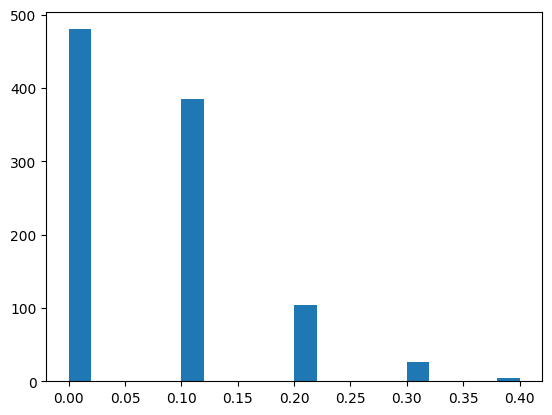

In [ ]:
plot_random_histogram(true_)

# Exercise 2

⭐ **YOUR TURN!** ⭐  So far, we saw the prompt as a given. However, the prompt design highly influences the outcome.

**REMINDER**: To use OpenAI models, you need to create an acoount and an API KEY. Follow [this tutorial](https://www.merge.dev/blog/chatgpt-api-key) to do so.

In [ ]:
API_KEY = "sk-..."
MODEL_NAME = "gpt-3.5-turbo-0125"
CLIENT = OpenAI(api_key=API_KEY)

Code for visualizing the output.

In [ ]:
from IPython.core.display import display, HTML

def visualize(answer):
  answer_html = f"<p>{answer}</p>".replace("\n", "</p><p>")
  in_html = f"""
            <h3>Output:</h3>
            {answer_html}
            """
  display(HTML(in_html))

Consider the following examples (from [Financial Times](https://www.ft.com/content/38be4231-21cf-46e3-8b6a-88a4e923f01c), [Reuters](https://www.reuters.com/business/finance/prosecutors-visit-dws-offices-again-over-alleged-greenwashing-2024-02-01/) and [DWS Homepage](https://www.dws.com/en-ch/solutions/sustainability/)):

In [ ]:
### Statements about DWS ESG practices

example_sources = """
SOURCE REUTERS:
U.S. regulators said in September that DWS was due to pay $25 million to settle
charges over misstatements regarding its environmental, social, and governance (ESG)
investing and failures in policies designed to prevent money laundering.

------

SOURCE Financial Times:
DWS made misleading statements in its 2020 annual report over the size of its ESG assets.
A executive claimed she was fired after informally raising her concerns internally and
subsequently filed a formal whistleblower complaint.

------
SOURCE DWS:
DWS has long recognized the importance of ESG factors for investors and was among the early
signatories of the United Nations-backed Principles for Responsible Investment (PRI) in 2008.
"""

In this exercise, we want to learn about the power of prompt engineering. Prompting engineering can be seen as a iterative process of refining the instruction to a model. We want to iteratively distill judgements on DWS' ESG practices through the given sources. We start by creating a summary. Thereby, we want to follow general prompt engineering guidelines.

***1. Write clear and specific instructions***

The effort you put in equals to the results you get out.

***2. Structure the text: Use Delimiters***

For the model to understand content correctly, it is extremely helpful to use delimiters to separate texts from each other (see for instance "-----" above).

In [ ]:
# Start with a summary
prompt = f""" Your are a ESG analyst with the target of analysing the company DWS.

You are provided with the following sources about the company delimited in <>.

<{example_sources}>

Please summarise the companies' integration of ESG.
"""

answer = get_model_response(CLIENT, MODEL_NAME, prompt)
visualize(answer)

This is a good summary for this one case but if you have much more sources or companies, the outcome may need to be refined.

***3. Iteratively refine the task***

Prompt Engineering is essentially a process of iteratively refining the task for your need.

Your ⭐first task⭐ is to transform the output in a list format of negative and positive aspects. There is no golden solution to these tasks, you can play around with alternatives that you like.

In [ ]:
### TASK 1

# Positive and negative points
prompt = ### YOUR CODE HERE ###

answer = get_model_response(CLIENT, MODEL_NAME, prompt)
visualize(answer)

***4. Convert the output into a structured format***

Depending on the task and evaluation strategy, different formats might be helpful.

Your ⭐second task⭐ is to transform the list of negative and positive aspects into JSON format (if you don't know, just ask the model to produce it).

In [ ]:
### TASK 2

# Positive and negative points in JSON
prompt = ### YOUR CODE HERE ###

answer = get_model_response(CLIENT, MODEL_NAME, prompt)
visualize(answer)

***5. Use vast model capabilities***

Apart from summarization or question answering, LLMs typically possess vast capabilities like reflecting on the output or providing helpful feedback.

Your ⭐third task⭐ is to use the models capabilities to reflect on the outcome. Ask the model to critically question the companies' ESG statements.

In [ ]:
### TASK 3

# Positive and negative points in JSON
prompt = ### YOUR CODE HERE ###

answer = get_model_response(CLIENT, MODEL_NAME, prompt)
visualize(answer)

***Further ressources:***

Of course, there is much more depth to Prompt Engineering. The following sources could help to refine knowledge further:
- Free course on [Prompt Engineering](https://learn.deeplearning.ai/chatgpt-prompt-eng/)
- Article on [Prompt Engineering 101]( https://hackernoon.com/prompt-engineering-101-i-unveiling-principles-and-techniques-of-effective-prompt-crafting)

## Solution

**IMPORTANT**: There is no golden solution to these tasks, you can play around with alternatives that you like.

In [ ]:
### TASK 1

# Positive and negative points
prompt = f""" Your are a ESG analyst with the target of analysing the company DWS.

You are provided with the following sources about the company delimited in <>.

<{example_sources}>

Please summarise the companies' integration of ESG the positive and negative aspects of DWS' activities.
For this, create two lists that contain short bullet points.
"""

answer = get_model_response(CLIENT, MODEL_NAME, prompt)
visualize(answer)

In [ ]:
### TASK 2

# Positive and negative points in JSON
prompt = f""" Your are a ESG analyst with the target of analysing the company DWS.

You are provided with the following sources about the company delimited in <>.

<{example_sources}>

Please summarise the companies' integration of ESG the positive and negative aspects of DWS' activities.
For this, create two lists that contain short bullet point summaries.

Format this output in a JSON format with the keys "positive_asepects" and "negative_aspects".
"""

answer = get_model_response(CLIENT, MODEL_NAME, prompt)
visualize(answer)

In [ ]:
### TASK 3

# Positive and negative points in JSON
prompt = f""" Your are a ESG analyst with the target of analysing the company DWS.

You are provided with the following sources about the company delimited in <>.

<{example_sources}>

Please critically reflect on the statements of DWS in the light of all sources.
How trustworthy are their statements?
End your judgment with a score from 1 (not trustworthy) to 10 (very trustworthy).
"""

answer = get_model_response(CLIENT, MODEL_NAME, prompt)
visualize(answer)

# Exercise 3

⭐ **YOUR TURN!** ⭐ again. Now, you should have a feeling for creating a prompt. Furthermore, we experimented with argueing over content - be it classification, summarization or structured output.

However, until now, we provided the external content. What if we want to analyse full reports with LLMs? For this, we will use a technique called Retrieval Augmented Generation (RAG). Essentially, it has two steps: (1) retrieving relevant content for a question/task from a source like reports and (2) including these contents into the prompt and create an answer based on the content.

This exercise will be inspired by the paper "[Combining AI and Domain Expertise to Assess Corporate Climate Transition Disclosures](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4826207)". Their pipeline looks as follows:
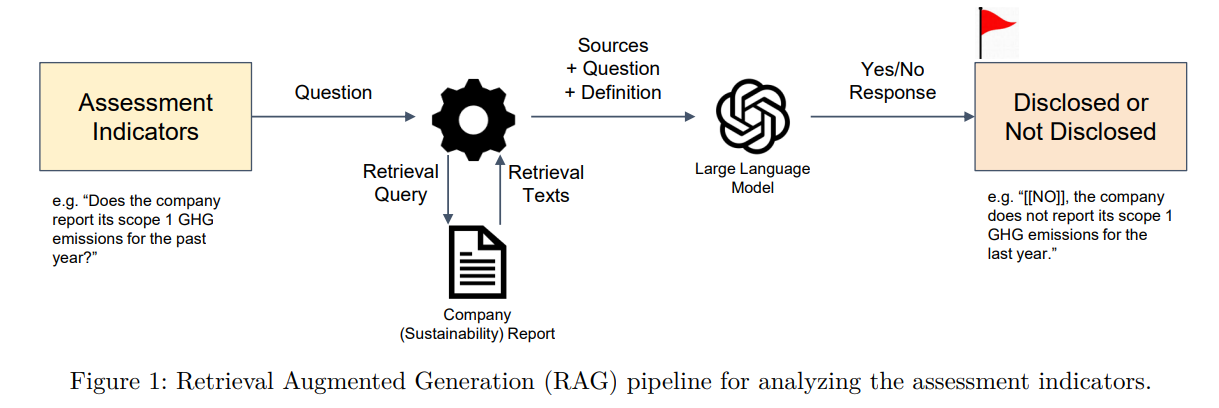

Use a question, find relevant content to the question in sustainability reports and then augment the prompt and answer the question. We just use their functions in the code to create the pipeline (see [their GitHub](https://github.com/tobischimanski/transition_NLP/tree/main)). This, in turn, uses LlamaIndex, an open-source framework, for the creation of the report-level dataset.

We clone their GitHub in here because this gives us access to real reports.

In [ ]:
!git clone https://github.com/tobischimanski/transition_NLP.git
# move to folder and show content
%cd transition_NLP/
%ls Test_Data/

Cloning into 'transition_NLP'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 94 (delta 39), reused 37 (delta 7), pack-reused 0
Receiving objects: 100% (94/94), 15.18 MiB | 27.76 MiB/s, done.
Resolving deltas: 100% (39/39), done.
/content/transition_NLP
CSR_IP_2022.pdf  CSR_VOW3_2022.pdf


We see two reports. One of them is Volkswagen's 2022 sustainability report: "CSR_VOW3_2022.pdf".

In [ ]:
from llama_index.core.prompts.base import PromptTemplate
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from llama_index.core.node_parser import SentenceSplitter
from llama_index.embeddings.openai import OpenAIEmbedding

# function that takes the report and creates the retriever (with indexes etc.)
def createRetriever(REPORT, CHUNK_SIZE, CHUNK_OVERLAP, TOP_K):
    ''' Create a relevant paragraph retriever for a document
        Args:
            REPORT (string): string containing the location of a report
            CHUNK_SIZE (int): desired word count of the paragraphs
            CHUNK_OVERLAP (int): overlap of the paragraphs
            TOP_K (int): number of retrieved paragraphs for a search
        Returns:
            retriever (object): retriever to retrieve paragraphs
    '''
    # load in document
    documents = SimpleDirectoryReader(input_files=[REPORT]).load_data()
    parser = SentenceSplitter(chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)  # tries to keep sentences together
    nodes = parser.get_nodes_from_documents(documents)

    # build indexes
    embed_model = OpenAIEmbedding(model="text-embedding-3-small")
    index = VectorStoreIndex(
        nodes,
        embed_model=embed_model
    )

    # configure retriever
    retriever = VectorIndexRetriever(
        index=index,
        similarity_top_k=TOP_K,
    )
    return retriever

def createSources(retriever, query):
    ''' Use the retriever to obtain sources
        Args:
            retriever (object): retriever to retrieve paragraphs
            query (string): search string
        Returns:
            sources_block (string): sources in a structured output
    '''
    # Query content
    retrieved_nodes = retriever.retrieve(query)
    # create the "sources" block
    sources = []
    for i in retrieved_nodes:
        page_num = i.metadata['page_label']
        # remove "\n" from the sources
        source = i.get_content().replace("\n", "")
        sources.append(f"PAGE {page_num}: {source}")
    sources_block = "\n\n\n".join(sources)
    return sources_block

Since we are used OpenAI models for the search and generation, we again need our OpenAI key. Follow [this tutorial](https://www.merge.dev/blog/chatgpt-api-key) to create the key.

In [ ]:
# these commands just make the openai key globally available for both OpenAI and LLamaIndex
os.environ["OPENAI_API_KEY"] = "sk-..."
openai.api_key = "sk-..."

Your ⭐first task⭐ is to make sense of the code. You just use the code to retrieve sources from a report. For this, you first need to create a retriever and then use the retriever and a question to retrieve sources.

In [ ]:
### TASK 1.1
# Create Retriever

# We use a report that is available in the GitHub of the project: CSR_VOW3_2022.pdf
REPORT = "./Test_Data/CSR_VOW3_2022.pdf"
# CHUNK_SIZE (int): desired word count of the paragraphs
### YOUR CODE HERE ###

# CHUNK_OVERLAP (int): overlap of the paragraphs
### YOUR CODE HERE ###

# TOP_K (in): number of retrieved paragraphs for a search
### YOUR CODE HERE ###

# Create retriever (this may take 30 seconds)
### YOUR CODE HERE ###

In [ ]:
### TASK 1.2
# Obtain Sources

# Question inspired by: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4826207
question = "Does the company report its GHG emission reduction interim targets for achieving the overall goal?"

sources = ### YOUR CODE HERE ###

Your ⭐second task⭐ is to help to create a prompt template that uses the sources to answer the question.

Hint: you can also look into [the paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4826207) for a very detailled prompt.

In [ ]:
### TASK 2

### YOUR CODE HERE ###
prompt_template = f"""
{sources}


{question}
"""

print(prompt_template)

Your ⭐third task⭐ is to use the prompt to answer the question. Hint: See the functions used in Exercise 2.

In [ ]:
### TASK 3

### YOUR CODE HERE ###

**Nice to know**: This is the naive way of implementing RAG. Better retrieval algorithms and generation models will improve the performance of the RAG system drastically (see for instance [this publication at ACL](https://arxiv.org/abs/2402.08277#:~:text=Advances%20towards%20more%20faithful%20and,the%20answers%20on%20reliable%20sources.) - the most important AI conference for Natural Language Processing). There is also projects that use [RAG to incorporate the guidelines of the Taskforce on Climate-related Financial Disclosures](https://aclanthology.org/2023.emnlp-demo.3/) and [RAG for assessing companies' nature disclosures](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4860331).

## Solution

In [ ]:
### TASK 1.1
# Create Retriever

# We use a report that is available in the GitHub of the project: CSR_VOW3_2022.pdf
REPORT = "./Test_Data/CSR_VOW3_2022.pdf"
# CHUNK_SIZE (int): desired word count of the paragraphs
CHUNK_SIZE = 200
# CHUNK_OVERLAP (int): overlap of the paragraphs
CHUNK_OVERLAP = 50
# TOP_K (in): number of retrieved paragraphs for a search
TOP_K = 5

# Create retriever (this may take 30 seconds)
retriever = createRetriever(REPORT, CHUNK_SIZE, CHUNK_OVERLAP, TOP_K)

In [ ]:
### TASK 1.2
# Obtain Sources

# Question inspired by: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4826207
question = "Does the company report its GHG emission reduction interim targets for achieving the overall goal?"

sources = createSources(retriever, question)
visualize(sources)

In [ ]:
### TASK 2

prompt_template = f"""You are a senior sustainability analyst with expertise in climate science evaluating a company ’s climate - related transition plan and strategy.

You are presented with the following sources from the company ’s report :
--------------------- [BEGIN OF SOURCES]\n
{sources}\n
--------------------- [END OF SOURCES]\n
Given the source information and no prior knowledge , your main task is to respond to the posed question encapsulated in "||".
Question : ||{question}||

Start your answer with a "[[YES]]" or "[[NO]]" depending on whether you would answer the question with a yes or no.
Always compliment your judgment on yes or no with a short explanation that summarizes the sources in an informative way , i.e. provide details.

Format your answer in JSON format with the two keys : ANSWER (this should contain your answer string without sources), and SOURCE_PAGES (this should be a list of the SOURCE numbers that were referenced in your answer).
Your FINAL_ANSWER in JSON (ensure there’s no format error):
"""

print(prompt_template)

In [ ]:
### TASK 3

answer = get_model_response(CLIENT, MODEL_NAME, prompt_template)
visualize(answer)